<a href="https://colab.research.google.com/github/selvam85/Cat-Dog-Classifier/blob/master/DNN_using_plain_TF_Cat_vs_Dog_classifier_Kaggle_dataset/DNN%20using%20plain%20TF%20-%20Cat%20vs%20Dog%20classifier_Colab%20file_v2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
import numpy as np
import h5py
import math
import time
from random import shuffle
import matplotlib.pyplot as plt
from tensorflow.contrib.layers import fully_connected, l2_regularizer
from tensorflow.contrib.framework import arg_scope
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

### Util functions

In [0]:
def load_dataset():
    
    lmd_tic = time.time()
    
    X_full_dataset = []
    Y_full_dataset = []
    filename_prefix = '/content/gdrive/My Drive/DeepLearning/Datasets/Kaggle_Cat_Vs_Dog_normalized/dog_vs_cat_normalized_dataset_kaggle_128px_'
    
    for i in range(1, 26):
        
        filename = filename_prefix + str(i) + ".h5"
        with h5py.File(filename, "r") as f:
    
            #print(list(f.keys()))
            #x_mini_data = None
            #y_mini_data = None
            
            X_full_dataset.append(f["input_data"][:])
            Y_full_dataset.append(f["input_labels"][:])

            #x_mini_data = f["input_data"][:]
            #y_mini_data = f["input_labels"][:]
    
    lmd_toc = time.time()
    print('Time taken to load the data set is', ((lmd_toc-lmd_tic) * 1000), 'ms')
    
    #return x_mini_data, y_mini_data
    return X_full_dataset, Y_full_dataset

In [0]:
def get_shuffled_indices(start_value, last_value):
    
    temp = np.arange(start_value, last_value)
    shuffle(temp)
    
    return temp

In [0]:
def create_random_mini_batches(X, Y, n_classes = 2, mini_batch_size = 32):
    
    m = X.shape[0] # number of training examples
    mini_batches = []
    
    #print("Shape of X =", X.shape)
    #print("Shape of Y =", Y.shape)
    
    #Reshaping to convert Y to a 2D array from a rank one array
    Y = Y.reshape(Y.shape[0], 1)
    
    #Shuffle the data in each of the mini batch
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :]
    
    n_mini_batches = math.ceil(m / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(n_mini_batches):
        
        start_pos = k * mini_batch_size
        end_pos = min(start_pos + mini_batch_size, m)
        
        mini_batch_X = shuffled_X[start_pos : end_pos, :]
        mini_batch_Y = shuffled_Y[start_pos : end_pos, :]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### Build the DNN using plain TensorFlow

**Step 1 - Code the individual ops in the computation graph**
- Create Placeholders for X, Y
- Create the nn_model - all the layers and initialize them
- Compute the cost
- Create the optimizer to minimize the cost
- Evaluate the model

**Step 2 - Build the computation graph**
- Combine all the steps in Step 1 to build the computation graph
- Initialize the variables
- Create a Saver object to save the learnt parameters after the model is trained

**Step 3 - Execute the graph**
- Create mini batches so that gradient descent works on these mini batches for every step instead of all instances
- Train the model for a given number of epochs
- Print the cost, train accuracy & test accuracy at regular interval of epochs
- Plot the training error (cost) vs epochs
- Save the parameters

**Step 4 - Predict for any data**
- Build a method to pass random data for the model to predict based on the parameters learnt through training

### Create the placeholders

In [0]:
def create_placeholders(n_inputs):
    '''
    n_inputs - A scalar containing the number of input features
    '''
    
    X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
    Y = tf.placeholder(tf.float32, shape = (None, 1), name = 'Y')
    
    return X, Y

### Create the NN model

In [0]:
def nn_model(X, n_neurons):
    '''
    X - input Tensor X
    n_neurons - A scalar containing the number of neurons in each layer including both hidden layers and output layer 
    '''
    #with arg_scope([fully_connected], weights_regularizer = l2_regularizer(scale = 0.01)):
    hidden_layer_1 = fully_connected(X, n_neurons['hidden_layer_1'], scope = 'hidden_layer_1')
    hidden_layer_2 = fully_connected(hidden_layer_1, n_neurons['hidden_layer_2'], scope = 'hidden_layer_2')
    hidden_layer_3 = fully_connected(hidden_layer_2, n_neurons['hidden_layer_3'], scope = 'hidden_layer_3')
    hidden_layer_4 = fully_connected(hidden_layer_3, n_neurons['hidden_layer_4'], scope = 'hidden_layer_4')
    hidden_layer_5 = fully_connected(hidden_layer_4, n_neurons['hidden_layer_5'], scope = 'hidden_layer_5')
    logits = fully_connected(hidden_layer_3, n_neurons['output_layer'], activation_fn = None, scope = 'output_layer')
    
    return logits

### Compute the cost

In [0]:
def compute_cost(labels, logits):
    '''
    labels - label tensor Y
    logits - Tensor containing the values of the output layer before passing to the activation function
    '''
    
    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels = labels, logits = logits)
    cost = tf.reduce_mean(cross_entropy, name = 'cost')
    #base_cost = tf.reduce_mean(cross_entropy)
    #reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    #cost = tf.add_n([base_cost] + reg_losses, name = 'cost')
    
    return cost

### Create the optimizer and the training operation

In [0]:
def optimizer(learning_rate, cost):
    '''
    learning_rate - A scalar value containing the learning rate for the backpropagation step
    cost - Overall cost from the forward propagation step for one set of mini batch instance
    '''
    
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(cost)
    
    return training_op

### Evaluate the model

We will use accuracy as the evaluation metric

In [0]:
def evaluate_model(logits, Y):
    '''
    logits - An array containing the values from the output layer
    Y - An array containing the labels
    '''
    
    #Compute the probability using the sigmoid function
    y_pred = tf.nn.sigmoid(logits)
    #Convert it to 0 or 1 class based on the probability and cast it to integer
    y_pred = tf.cast(y_pred > 0.5, tf.int64)
    #y_pred = tf.cast(tf.round(y_pred), tf.int64)
    
    #Create a boolean tensor by comparing the model prediction against the labels
    correct_prediction = tf.equal(y_pred, tf.cast(Y, tf.int64))
    #Compute the accuracy across all the instances
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    return accuracy

### Build the computation graph & execute it

In [0]:
def train_model(n_neurons, n_inputs, learning_rate = 0.01, mini_batch_size = 32, n_epochs = 20, print_cost = False):
    
    tf.reset_default_graph()
    
    #Declare and initialize the required variables
    costs = []
    
    #Create Placeholder
    X, Y = create_placeholders(n_inputs)
    
    #Create the nn_model
    logits = nn_model(X, n_neurons) 
    
    #Compute the cost
    cost = compute_cost(Y, logits)
    
    #Optimize the cost using Gradient Descent Optimizer
    training_op = optimizer(learning_rate, cost)
    
    #Evaluate the model
    accuracy = evaluate_model(logits, Y)
    
    #Initialize the variables
    init = tf.global_variables_initializer()
    
    #Create the Saver object
    saver = tf.train.Saver()
    
    #Execute the Graph - Train the model
    with tf.Session() as sess:
        init.run()
        
        X_full_dataset, Y_full_dataset = load_dataset()
        
        for epoch in range(1, n_epochs + 1):
            n_mini_batches = 0
            epoch_cost = 0
            total_time_taken_to_create_mini_batches = 0
            
            tic = time.time()
            
            shuffled_indices = get_shuffled_indices(0, 25)
            for j in shuffled_indices:
                X_mini = None
                Y_mini = None
                #X_mini, Y_mini = load_mini_dataset(j)
                
                X_mini = X_full_dataset[j]
                Y_mini = Y_full_dataset[j]
                
                rmb_tic = time.time()
                mini_batches = None
                mini_batches = create_random_mini_batches(X_mini, Y_mini, mini_batch_size = mini_batch_size)
                rmb_toc = time.time()
                total_time_taken_to_create_mini_batches += (rmb_toc-rmb_tic)
                            
                for mini_batch in mini_batches:
                    n_mini_batches += 1
                    (X_mini_batch, Y_mini_batch) = mini_batch
                    _, mini_batch_cost = sess.run([training_op, cost], feed_dict = {X: X_mini_batch, Y: Y_mini_batch})

                    epoch_cost += mini_batch_cost
            
            toc = time.time()
            training_time = ((toc-tic) - total_time_taken_to_create_mini_batches) * 1000
            print('Epoch', epoch, 
                  '| Mini Batch Creation:', total_time_taken_to_create_mini_batches * 1000, 'ms',
                  '| Training Time:', training_time, 'ms',
                  '| Total Time:', ((toc-tic) * 1000), 'ms')
            
            epoch_cost = epoch_cost / n_mini_batches
            train_accuracy = accuracy.eval(feed_dict = {X: X_mini_batch, Y: Y_mini_batch})
            #cval_accuracy = accuracy.eval(feed_dict = {X: X_cval, Y: Y_cval})
            
            if print_cost and epoch % 2 == 0:
                print('At epoch', epoch, 'Cost =', epoch_cost, '| Train Accuracy =', train_accuracy)
            
            if epoch % 2 == 0:
                costs.append(epoch_cost)
            
        saver_path = saver.save(sess, './my_model_final.ckpt')
        
    #print('Final - Train Accuracy =', train_accuracy, '| CVal Accuracy =', cval_accuracy)
    print('Final - Train Accuracy =', train_accuracy)
        
    plt.plot(costs)
    plt.xlabel('# of Epochs')
    plt.ylabel('Training Error - Cost')
    plt.title('Training Error Vs Epochs')
    plt.show()
    
    return saver_path

Time taken to load the data set is 66084.37871932983 ms
Epoch 1 | Mini Batch Creation: 2445.2598094940186 ms | Training Time: 5458.923101425171 ms | Total Time: 7904.182910919189 ms
Epoch 2 | Mini Batch Creation: 1574.878454208374 ms | Training Time: 4479.424238204956 ms | Total Time: 6054.30269241333 ms
At epoch 2 Cost = 0.6924373887079146 | Train Accuracy = 0.4375
Epoch 3 | Mini Batch Creation: 1562.803030014038 ms | Training Time: 4376.692056655884 ms | Total Time: 5939.495086669922 ms
Epoch 4 | Mini Batch Creation: 1559.8397254943848 ms | Training Time: 4418.298959732056 ms | Total Time: 5978.13868522644 ms
At epoch 4 Cost = 0.6934939684617855 | Train Accuracy = 0.4375
Epoch 5 | Mini Batch Creation: 1552.8011322021484 ms | Training Time: 4304.287910461426 ms | Total Time: 5857.089042663574 ms
Epoch 6 | Mini Batch Creation: 1559.1671466827393 ms | Training Time: 4332.305669784546 ms | Total Time: 5891.472816467285 ms
At epoch 6 Cost = 0.6933322460450175 | Train Accuracy = 0.46875
Ep

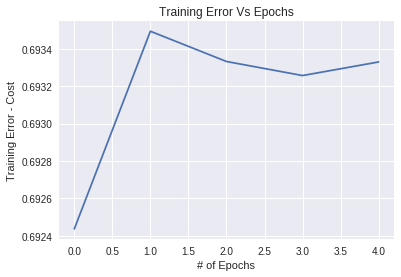

'./my_model_final.ckpt'

In [13]:
n_neurons = {'hidden_layer_1': 50,
             'hidden_layer_2': 50,
             'hidden_layer_3': 50,
             'hidden_layer_4': 50,
             'hidden_layer_5': 30,
             'output_layer': 1}
n_input_features = 49152
train_model(n_neurons, n_input_features, learning_rate = 0.01, n_epochs = 10, mini_batch_size = 32,
            print_cost = True)